In [1]:
!pip install Nasdaq-Data-Link

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
import nasdaqdatalink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
np.random.seed(1234)  

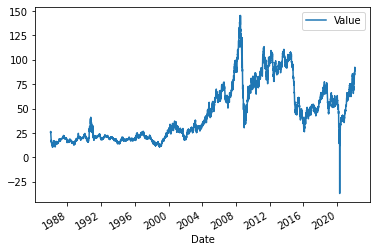

In [3]:
# WTI Crude Oil price from the US Department of Energy
mydata = nasdaqdatalink.get("EIA/PET_RWTC_D") 
mydata.plot()

In [4]:
# Убрал отрицительное значение
mydata.iloc[np.where(mydata<0)[0], :] = 9.00

In [5]:
# Убрал даты - оставил только цены
mydata.reset_index(inplace=True)
mydata = mydata["Value"]

In [6]:
# Стандартизация
data_mean = mydata.mean()
data_std = mydata.std()
mydata = (mydata - data_mean) / data_std

In [7]:
# Генерация данных
data_width = 500
label_width = 50

def window(data, data_width, label_width):
  X = []
  y = []
  for i in range(data_width, len(data)-label_width):
    X.append(data.values[i-data_width:i])
    y.append(data.values[i:i+label_width])
  return (X, y)

X, y = window(mydata, data_width, label_width)

In [8]:
# Разделение на обучение, валидацию и тест
n = len(X)
train_X = X[0:int(n*0.7)]
val_X = X[int(n*0.7):int(n*0.9)]
test_X = X[int(n*0.9):]
train_y = y[0:int(n*0.7)]
val_y = y[int(n*0.7):int(n*0.9)]
test_y = y[int(n*0.9):]

In [9]:
# Погдотовка данных для нейронной сети
train_X = np.asarray(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
val_X = np.asarray(val_X)
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))
test_X = np.asarray(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
train_y = np.asarray(train_y)
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
val_y = np.asarray(val_y)
val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
test_y = np.asarray(test_y)
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

In [10]:
# Linear model

Linear_model = Sequential()
Linear_model.add(Dense(units=50, activation='sigmoid', input_shape=(train_X.shape[1], )))
Linear_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
Linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                25050     
                                                                 
Total params: 25,050
Trainable params: 25,050
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Dense model

Dense_model = Sequential()
Dense_model.add(Dense(512, activation='relu', input_shape=(train_X.shape[1], )))
Dense_model.add(Dense(50, activation='sigmoid'))

Dense_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
Dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               256512    
                                                                 
 dense_2 (Dense)             (None, 50)                25650     
                                                                 
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0
_________________________________________________________________


In [12]:
# LSTM model (easy)

eLSTM_model = Sequential()

eLSTM_model.add(LSTM(
         input_shape=(train_X.shape[1], train_X.shape[2]),
         units=32,
         return_sequences=False))

eLSTM_model.add(Dense(units=50, activation='sigmoid'))
eLSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
eLSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_3 (Dense)             (None, 50)                1650      
                                                                 
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________


In [13]:
# LSTM model (complex)

cLSTM_model = Sequential()

cLSTM_model.add(LSTM(
         input_shape=(train_X.shape[1], train_X.shape[2]),
         units=100,
         return_sequences=True))
cLSTM_model.add(Dropout(0.2))

cLSTM_model.add(LSTM(
          units=50,
          return_sequences=False))
cLSTM_model.add(Dropout(0.2))

cLSTM_model.add(Dense(units=50, activation='sigmoid'))
cLSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
cLSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 500, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
Total params: 73,550
Trainable params: 73,550
Non-trainable params: 0
_________________________________________________________________


In [99]:
print("LSTM")
history_elstm = eLSTM_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])
history_clstm = cLSTM_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])
print("Linear")
history_linear = Linear_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])
history_dense = Dense_model.fit(train_X, train_y, epochs=20, batch_size=200, validation_data=(val_X, val_y), verbose=1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=2, mode='min')])

LSTM
Epoch 1/20
31/31 [==============================] - 8s 244ms/step - loss: 0.5752 - mean_absolute_error: 0.6674 - val_loss: 0.3596 - val_mean_absolute_error: 0.4760
Epoch 2/20
31/31 [==============================] - 8s 243ms/step - loss: 0.5750 - mean_absolute_error: 0.6671 - val_loss: 0.3587 - val_mean_absolute_error: 0.4750
Epoch 3/20
31/31 [==============================] - 8s 269ms/step - loss: 0.5747 - mean_absolute_error: 0.6667 - val_loss: 0.3590 - val_mean_absolute_error: 0.4763
Epoch 4/20
31/31 [==============================] - 7s 239ms/step - loss: 0.5744 - mean_absolute_error: 0.6666 - val_loss: 0.3574 - val_mean_absolute_error: 0.4741
Epoch 5/20
31/31 [==============================] - 7s 239ms/step - loss: 0.5742 - mean_absolute_error: 0.6663 - val_loss: 0.3568 - val_mean_absolute_error: 0.4735
Epoch 6/20
31/31 [==============================] - 8s 243ms/step - loss: 0.5740 - mean_absolute_error: 0.6662 - val_loss: 0.3554 - val_mean_absolute_error: 0.4714
Epoch 7/20


In [100]:
# "Базовые" предсказания
repeat_pred = []
naive_pred = []
for x in test_X.reshape(test_X.shape[0], test_X.shape[1]):
  repeat_pred.append(x[-50:])
  naive_pred.append(np.asarray([x[-1] for i in range(50)]))

In [101]:
print(f'naive model mean_absolute_error: {mean_absolute_error(test_y.reshape(test_y.shape[0], test_y.shape[1]), naive_pred):.4f}\n'+
      f'repeat model mean_absolute_error: {mean_absolute_error(test_y.reshape(test_y.shape[0], test_y.shape[1]), repeat_pred):.4f}')

naive model mean_absolute_error: 0.2028
repeat model mean_absolute_error: 0.3108


In [102]:
for model, name in [(eLSTM_model, 'simple LSTM'), (cLSTM_model, 'complex LSTM'), (Linear_model, 'linear model'), (Dense_model, 'simple NN')]:
 print(name)
 model.evaluate(test_X, test_y)

simple LSTM
27/27 [==============================] - 1s 29ms/step - loss: 0.1336 - mean_absolute_error: 0.2509
complex LSTM
27/27 [==============================] - 3s 111ms/step - loss: 0.1358 - mean_absolute_error: 0.2561
linear model
27/27 [==============================] - 0s 1ms/step - loss: 0.5491 - mean_absolute_error: 0.5909
simple NN
27/27 [==============================] - 0s 2ms/step - loss: 0.4121 - mean_absolute_error: 0.5036


In [103]:
pred_e = eLSTM_model.predict(test_X)
pred_c = cLSTM_model.predict(test_X)
pred_d = Dense_model.predict(test_X)
pred_l = Linear_model.predict(test_X)

27/27 [==============================] - 0s 1ms/step


In [104]:
# Форматирование предсказаний вариант 1
def transform_pred1(pred):
  pred_data = []
  for i, val in enumerate(pred):
    if i==0: 
      pred_data = val
      continue
    else: pred_data = np.append(pred_data,val[-1])
  print(len(pred_data))
  return pred_data

In [105]:
# Форматирование предсказаний вариант 2
def transform_pred2(pred):
  pred_data = []
  for i in range(len(pred)//50+1):
    pred_data.extend(pred[i*50])
  pred_data.extend(pred[-1][-len(pred)%50+1:])
  print(len(pred_data))
  return pred_data

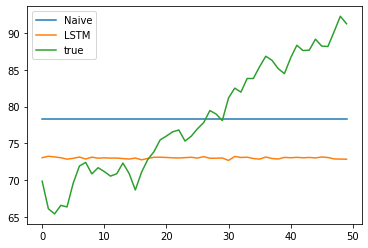

In [106]:
# Сравнение предсказаний для конкретного окна
plt.plot(naive_pred[-1] * data_std + data_mean, label='Naive')
plt.plot(pred_e[-1] * data_std + data_mean, label='LSTM')
plt.plot(test_y[-1] * data_std + data_mean, label='true')
plt.legend()
plt.show()

907


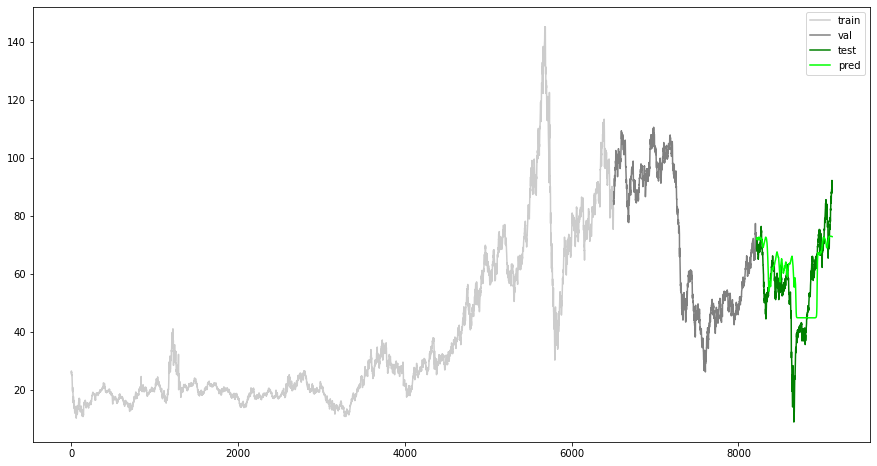

In [108]:
# Выбор предсказаний конкретной модели
pred_data = transform_pred1(pred_e)
# Отрисовка предсказаний 
plt.figure(figsize=(15,8))
plt.plot(mydata[:-len(pred_data)-len(val_X)] * data_std + data_mean, label="train", c='0.8')
plt.plot(mydata[-len(pred_data)-len(val_X):-len(pred_data)] * data_std + data_mean, label="val", c='gray')
plt.plot(pd.Series(mydata[-len(pred_data):] * data_std + data_mean), label="test", c='#008000')
plt.plot((pd.Series(pred_data, [len(mydata)-len(pred_data)+i for i in range(len(pred_data))]) * data_std + data_mean), label="pred", c='#00FF00')
plt.legend()
plt.show()